In [1]:
from gams.transfer import Container
import pandas as pd
from utils import read_gdx,read_scenarios,calc_cum_emis
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [2]:
# path1 = 'results/results_burke_cbudget1200_coop_ssp2_popshares.gdx'
# path2 = 'results/results_burke_cbudget1300_coop_ssp2_popshares.gdx'
# path3 = 'results/results_burke_cbudget1400_coop_ssp2_popshares.gdx'

# gdx = Container(path1)
# print(gdx.listVariables())

# tot_emis = read_scenarios([path1,path2,path3],['E','ABATEDEMI','TEMP_REGION','TEMP_REGION_DAM','DAMAGES','DAMFRAC'])
# tot_emis.head(10)

['C', 'CPC', 'K', 'I', 'S', 'RI', 'YGROSS', 'YNET', 'Y', 'CTX', 'E', 'EIND', 'MIU', 'ABATEDEMI', 'CCO2EIND', 'CCO2ETOT', 'UTILITY', 'ABATECOST', 'CPRICE', 'ABATECOST_PB', 'ABATECOST_ED', 'CPRICE_ED', 'CPRICE_PB', 'ELAND', 'FORC', 'TATM', 'TOCEAN', 'W_EMI', 'WCUM_EMI', 'RF', 'RFoth', 'TEMP_REGION', 'TEMP_REGION_DAM', 'DAMAGES', 'DAMFRAC', 'YNET_ESTIMATED', 'BIMPACT', 'OMEGA', 'KOMEGA']


In [28]:
paths = ['results/results_ssp1_cbudget1200.gdx',
         'results/results_ssp1_cbudget1300.gdx',
         'results/results_ssp1_cbudget1500.gdx',
         'results/results_ssp2_cbudget1200.gdx',
         'results/results_ssp2_cbudget1300.gdx',
         'results/results_ssp2_cbudget1500.gdx',
         'results/results_ssp3_cbudget2000.gdx',
         'results/results_ssp4_cbudget1500.gdx',
         'results/results_ssp5_cbudget1200.gdx',
         'results/results_ssp5_cbudget1300.gdx',
         'results/results_ssp5_cbudget1500.gdx']

data = read_scenarios(paths,['E','ABATEDEMI','TEMP_REGION','TEMP_REGION_DAM','DAMAGES','DAMFRAC'])
data['E'] = data['E']*5 #Adjust timestep
data['ssp'] = data['scen'].str.slice(0,4)
data['cbudget'] = data['scen'].str.slice(-4)
data.head(10)

,t_0,region,E,ABATEDEMI,TEMP_REGION,TEMP_REGION_DAM,DAMAGES,DAMFRAC,year,scen,ssp,cbudget
0,1,r5asia,78.586079,0.000000e+00,20.152972,20.152972,-7.428014e-11,2.206302e-12,2015,ssp1_cbudget1200,ssp1,1200
1,1,r5lam,15.193440,0.000000e+00,21.789048,21.789048,-2.891003e-10,3.331770e-11,2015,ssp1_cbudget1200,ssp1,1200
2,1,r5maf,21.914002,0.000000e+00,22.914034,22.914034,-3.269918e-10,4.258465e-11,2015,ssp1_cbudget1200,ssp1,1200
3,1,r5oecd,56.322147,1.776357e-15,12.193810,12.193810,-6.972556e-11,1.944040e-12,2015,ssp1_cbudget1200,ssp1,1200
4,1,r5ref,15.798612,0.000000e+00,8.758937,8.758937,-3.217213e-10,4.122848e-11,2015,ssp1_cbudget1200,ssp1,1200
5,2,r5asia,86.877468,4.994011e-01,20.491812,20.491812,3.303281e-01,-6.941755e-03,2020,ssp1_cbudget1200,ssp1,1200
6,2,r5lam,14.397031,5.796874e-02,22.113159,22.113159,5.470092e-02,-5.261861e-03,2020,ssp1_cbudget1200,ssp1,1200
7,2,r5maf,19.684106,8.374914e-02,23.273956,23.273956,6.520302e-02,-6.686510e-03,2020,ssp1_cbudget1200,ssp1,1200
8,2,r5oecd,50.065773,3.242877e-01,12.564263,12.564263,-3.456972e-02,8.581287e-04,2020,ssp1_cbudget1200,ssp1,1200
9,2,r5ref,15.185134,1.070190e-01,9.192282,9.192282,-4.325132e-02,4.604309e-03,2020,ssp1_cbudget1200,ssp1,1200


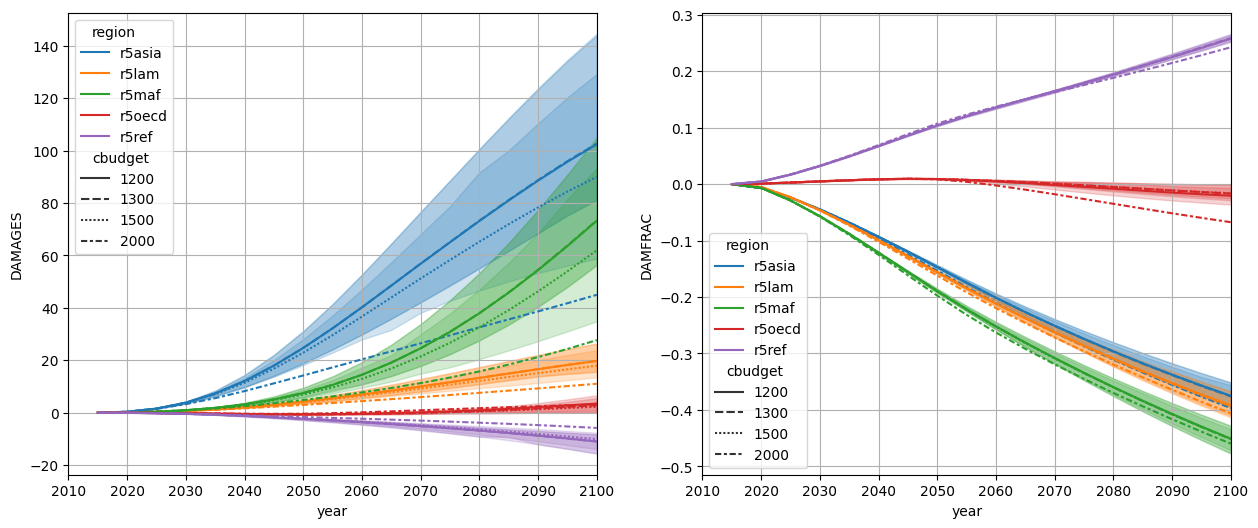

In [24]:
countries=data[(data['year'] <= 2100)]
fig,axs = plt.subplots(1,2,figsize=(15,6))
sns.lineplot(data=countries,x='year',y='DAMAGES',hue='region',style='cbudget',ax=axs[0]).grid(True)
sns.lineplot(data=countries,x='year',y='DAMFRAC',hue='region',style='cbudget',ax=axs[1]).grid(True)
axs[0].set(xlim=[2010,2100])
axs[1].set(xlim=[2010,2100])
plt.show()

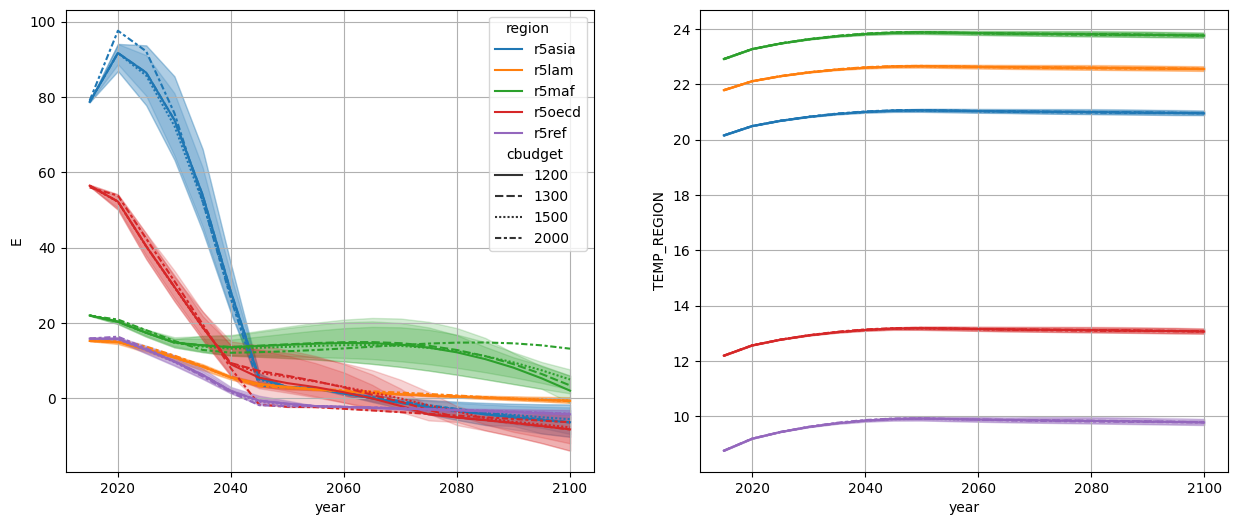

In [15]:
fig,axs = plt.subplots(1,2,figsize=(15,6))
sns.lineplot(data=countries,x='year',y='E',hue='region',style='cbudget',ax=axs[0]).grid(True)
sns.lineplot(data=countries,x='year',y='TEMP_REGION',hue='region',style='cbudget',legend=False,ax=axs[1]).grid(True)
plt.show()

<Axes: xlabel='year', ylabel='CUMEMI'>

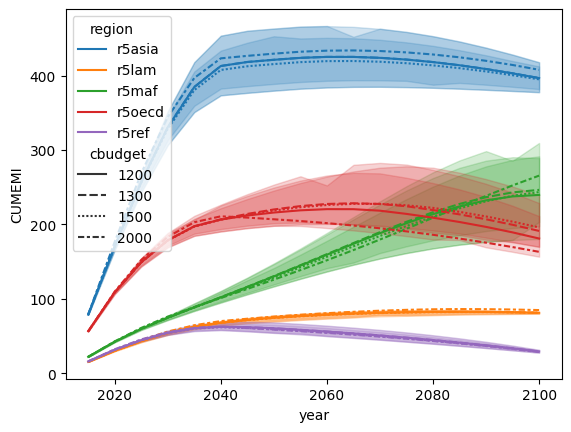

In [40]:
cum_emis = pd.DataFrame()

for ssp in ['ssp1','ssp2','ssp3','ssp4','ssp5']:
    cum_emis = pd.concat([cum_emis, calc_cum_emis(data[data['ssp'] == ssp])])

cum_emis['cbudget'] = cum_emis['scen'].str.slice(-4)
sns.lineplot(data=cum_emis,x='year',y='CUMEMI',hue='region',style='cbudget')

In [63]:
non_reg = read_scenarios(paths,['CCO2ETOT','TATM'])
non_reg['ssp'] = non_reg['scen'].str.slice(0,4)
non_reg['cbudget'] = non_reg['scen'].str.slice(-4)

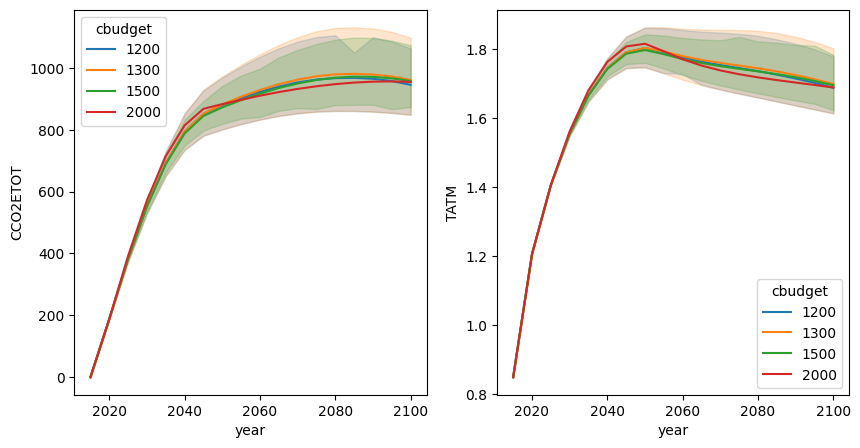

In [70]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
sns.lineplot(data=non_reg[non_reg['year'] <= 2100],x='year',y='CCO2ETOT',hue='cbudget',ax=axs[0])
sns.lineplot(data=non_reg[non_reg['year'] <= 2100],x='year',y='TATM',hue='cbudget',ax=axs[1])
plt.show()

In [73]:
paths2 = ['results/results_ssp2_noeffort_cbudget800.gdx',
          'results/results_ssp2_noeffort_cbudget1000.gdx',
          'results/results_ssp2_noeffort_cbudget1200.gdx']

no_effort = read_scenarios(paths2,['CCO2ETOT','TATM'])
no_effort['ssp'] = no_effort['scen'].str.slice(0,4)
no_effort['cbudget'] = no_effort['scen'].str.slice(-4).replace('t800','800')

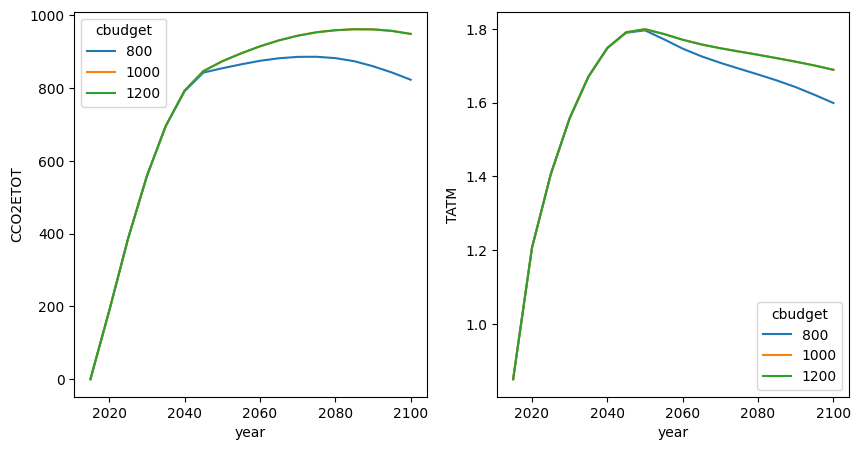

In [76]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
sns.lineplot(data=no_effort[no_effort['year'] <= 2100],x='year',y='CCO2ETOT',hue='cbudget',ax=axs[0])
sns.lineplot(data=no_effort[no_effort['year'] <= 2100],x='year',y='TATM',hue='cbudget',ax=axs[1])
plt.show()

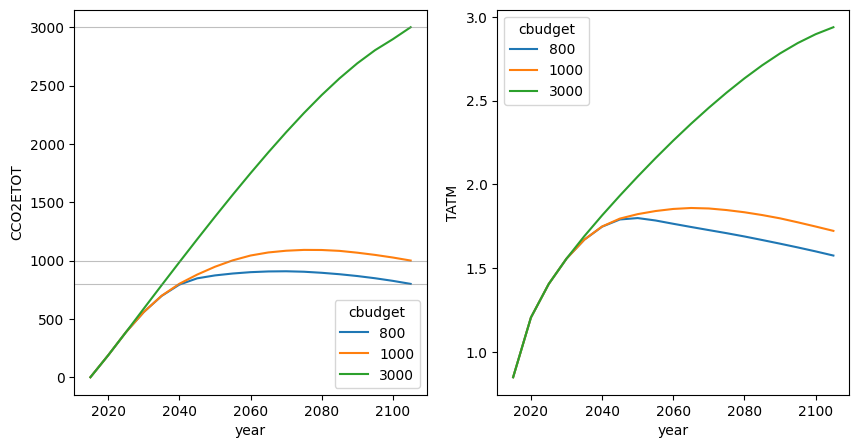

In [83]:
paths3 = ['results/results_ssp2_noeffort_noimpacts_cbudget800.gdx',
          'results/results_ssp2_noeffort_noimpacts_cbudget1000.gdx',
          'results/results_ssp2_noeffort_noimpacts_cbudget3000.gdx']

no_impacts = read_scenarios(paths3,['CCO2ETOT','TATM'])
no_impacts['ssp'] = no_impacts['scen'].str.slice(0,4)
no_impacts['cbudget'] = no_impacts['scen'].str.slice(-4).replace('t800','800')

fig,axs = plt.subplots(1,2,figsize=(10,5))
sns.lineplot(data=no_impacts[no_impacts['year'] <= 2105],x='year',y='CCO2ETOT',hue='cbudget',ax=axs[0])
axs[0].axhline(800,color='gray',alpha=0.5,linewidth=0.8)
axs[0].axhline(1000,color='gray',alpha=0.5,linewidth=0.8)
axs[0].axhline(3000,color='gray',alpha=0.5,linewidth=0.8)
sns.lineplot(data=no_impacts[no_impacts['year'] <= 2105],x='year',y='TATM',hue='cbudget',ax=axs[1])
plt.show()